In [4]:
%matplotlib inline
import helpers

In [5]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  0.1.65


In [6]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config(path="../aml_config/config.json")
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

Found the config file in: C:\Users\Thijs\Google Drive\LEGO Vision\Notebooks\aml_config\config.json
LEGO-Vision	westeurope	LEGO-Vision	westeurope


In [7]:
compute_target = ws.compute_targets()["LEGO-Visiongpu"]

In [8]:
experiment_name = 'naive-bayes-classifier'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [11]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir='../classification', target_path='lego-vision-classification', overwrite=True, show_progress=True)

AzureFile legovision1529597820 azureml-filestore-f0102bff-6d0a-47ad-b50c-4709fd2f206a


$AZUREML_DATAREFERENCE_0da65705ca634cf9816797fb307ff2fc

In [12]:
import os
script_folder = './lego-vision-classifier'
os.makedirs(script_folder, exist_ok=True)

In [60]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.metrics import classification_report,accuracy_score, fbeta_score

from sklearn.model_selection import train_test_split
import numpy as np

from azureml.core import Run
import helpers

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

classifiers = {'gaussian': GaussianNB(), 'bernoulli': BernoulliNB(), 'multinomial': MultinomialNB()}


# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--classifier', type=str, dest='classifier', help='What Naive Bayes classifier to use. gaussian, bernoulli, multinomial')
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'lego-vision-classification')
print('Data folder:', data_folder)

X, y = helpers.images_to_dataset(dataset_path=data_folder, to_grayscale=False, shape=(128,128), 
                                 smoothing=0.1, to_hog=True, pixels_per_cell=(8,8), cells_per_block=(8,8), orientations=9,
                                 denoising=0.2, samples=600)

X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# get hold of the current run
run = Run.get_submitted_run()

print('Train a naive bayes model, classifier: ', args.classifier)
clf = classifiers.get(args.classifier)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = accuracy_score(y_test, y_hat)
print("F-Beta with fbeta_score(y_test, y_pred, beta=0.6, 'macro')")
fbeta = fbeta_score(y_test, y_hat, beta=0.6, average='macro')

print(f"Accuracy: {acc}")
print(classification_report(y_test, y_hat))

run.log('classifier', args.classifier)
run.log('accuracy', np.float(acc))
run.log('fbeta-score', np.float(fbeta))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/nb-classifier.pkl')

Overwriting ./lego-vision-classifier/train.py


Data folder: C:\Users\Thijs\Google Drive\LEGO Vision\Notebooks\classification


c:\users\thijs\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Train a naive bayes model, classifier:  gaussian
Predict the test set
F-Beta with fbeta_score(y_test, y_pred, beta=1.0, 'micro')
Accuracy: 0.14285714285714285
                  precision    recall  f1-score   support

       2458-blue       0.00      0.00      0.00         1
     3003-yellow       0.00      0.00      0.00         0
        3020-red       0.33      1.00      0.50         1
3039-trans-clear       0.00      0.00      0.00         2
     3298-yellow       0.00      0.00      0.00         2
        3710-red       0.00      0.00      0.00         0
     6041-yellow       0.00      0.00      0.00         1

     avg / total       0.05      0.14      0.07         7

F-Score: 0.05782312925170067


c:\users\thijs\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thijs\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\users\thijs\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thijs\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with

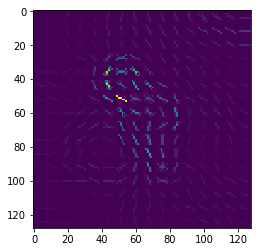

In [38]:
import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.metrics import classification_report,accuracy_score, fbeta_score

from sklearn.model_selection import train_test_split
import numpy as np

from azureml.core import Run
import helpers

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

classifiers = {'gaussian': GaussianNB(), 'bernoulli': BernoulliNB(), 'multinomial': MultinomialNB()}


# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
data_folder = os.path.join(r'C:\Users\Thijs\Google Drive\LEGO Vision\Notebooks', 'classification')
print('Data folder:', data_folder)

X, y = helpers.images_to_dataset(dataset_path=data_folder, to_grayscale=False, shape=(128,128), 
                                 smoothing=0.1, to_hog=True, pixels_per_cell=(8,8), cells_per_block=(8,8), orientations=9,
                                 denoising=0.2, samples=3)

X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# get hold of the current run
# run = Run.get_submitted_run()

print('Train a naive bayes model, classifier: ', 'gaussian')
clf = classifiers.get('gaussian')
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = accuracy_score(y_test, y_hat)
print("F-Beta with fbeta_score(y_test, y_pred, beta=1.0, 'micro')")
fbeta = fbeta_score(y_test, y_hat, beta=0.6, average='macro')

print(f"Accuracy: {acc}")
print(classification_report(y_test, y_hat))

print(f"F-Score: {fbeta}")

# run.log('classifier', args.classifier)
# run.log('accuracy', np.float(acc))
# run.log('fbeta-score', np.float(fbeta))

# os.makedirs('outputs', exist_ok=True)
# # note file saved in the outputs folder is automatically uploaded into experiment record
# joblib.dump(value=clf, filename='outputs/nb-classifier.pkl')

In [13]:
import shutil
shutil.copy('helpers.py', script_folder)

'./lego-vision-classifier\\helpers.py'

In [62]:
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--classifier': 'gaussian'
}
print(script_folder, script_params, compute_target)
est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                node_count=2,
                process_count_per_node=1,
                distributed_backend='mpi',     
                entry_script='train.py',
                conda_packages=['scikit-learn', 'matplotlib', 'scikit-image'],
                custom_docker_base_image='microsoft/mmlspark:gpu-0.12',
                use_gpu=True)

./lego-vision-classifier {'--data-folder': $AZUREML_DATAREFERENCE_workspacefilestore, '--classifier': 'gaussian'} <azureml.core.compute.batchai.BatchAiCompute object at 0x0000026772E695C0>


In [63]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
naive-bayes-classifier,naive-bayes-classifier_1539003586893,azureml.scriptrun,Running,Link to Azure Portal,Link to Documentation


In [64]:
from azureml.train.widgets import RunDetails
RunDetails(run).show()

_UserRun()

In [59]:
run.wait_for_completion(show_output=True) # specify True for a verbose log

RunId: naive-bayes-classifier_1538999230659

Streaming azureml-logs/20_image_build_log.txt

Logging into Docker registry: legovision6039404951.azurecr.io
Login Succeeded
Docker login(s) took 1.9605181217193604 seconds
Building image with name legovision6039404951.azurecr.io/azureml/azureml_0eaf77b3c7e13647c6f259e7a006e147
Sending build context to Docker daemon  115.7kB

Step 1/13 : FROM microsoft/mmlspark:gpu-0.12
 ---> 5ba44bcac7bc
Step 2/13 : USER root
 ---> Running in 235d512717ad
 ---> dfc6770b5224
Removing intermediate container 235d512717ad
Step 3/13 : RUN mkdir -p $HOME/.cache
 ---> Running in 8ed8c627c5ba
 ---> 4d95a6e65ddd
Removing intermediate container 8ed8c627c5ba
Step 4/13 : WORKDIR /
 ---> 1061a762318f
Removing intermediate container 6e6806bca957
Step 5/13 : COPY azureml-setup/99brokenproxy /etc/apt/apt.conf.d/
 ---> 0d41b328ba7d
Step 6/13 : RUN if dpkg --compare-versions `conda --version | grep -oE '[^ ]+$'` lt 4.4.0; then conda install conda==4.4.11 -c anaconda; fi
 ---

Verifying transaction: ...working... done
Executing transaction: ...working... done


  Running setup.py bdist_wheel for SecretStorage: started
  Running setup.py bdist_wheel for SecretStorage: finished with status 'done'
  Stored in directory: /home/mmlspark/.cache/pip/wheels/4e/5b/1b/be8c8a830a0243af85b2946a0aece2c6743d7f7f946977ed67
  Running setup.py bdist_wheel for pathspec: started
  Running setup.py bdist_wheel for pathspec: finished with status 'done'
  Stored in directory: /home/mmlspark/.cache/pip/wheels/45/cb/7e/ce6e6062c69446e39e328170524ca8213498bc66a74c6a210b
  Running setup.py bdist_wheel for pyyaml: started
  Running setup.py bdist_wheel for pyyaml: finished with status 'done'
  Stored in directory: /home/mmlspark/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
  Running setup.py bdist_wheel for antlr4-python3-runtime: started
  Running setup.py bdist_wheel for antlr4-python3-runtime: finished with status 'done'
  Stored in directory: /home/mmlspark/.cache/pip/wheels/ef/f6/18/ad300e691236a3408a99edc750484b56e8d6b11b2c38eacb1

Successfully built a260b3d9e8f7
Successfully tagged legovision6039404951.azurecr.io/azureml/azureml_0eaf77b3c7e13647c6f259e7a006e147:latest
Removing any dangling images
Docker build took 816.5764300823212 seconds
Logging into acr legovision6039404951.azurecr.io to do docker push
Login Succeeded
Pushing image azureml/azureml_0eaf77b3c7e13647c6f259e7a006e147 to acr legovision6039404951.azurecr.io
The push refers to a repository [legovision6039404951.azurecr.io/azureml/azureml_0eaf77b3c7e13647c6f259e7a006e147]
eed9ddeb38ea: Preparing
d14331323618: Preparing
3422424d0477: Preparing
114a49140bdb: Preparing
a06cd819521d: Preparing
9f50ec9d8e13: Preparing
e0e29897130f: Preparing
49ce251285dc: Preparing
de862cec50ac: Preparing
22ccacda0200: Preparing
eb934c8f6ea7: Preparing
ae84bde7eb3c: Preparing
d6f6196b0b3a: Preparing
4db07fac2067: Preparing
19e1b86a7280: Preparing
19d5748c63e7: Preparing
7028b03ecbb7: Preparing
407bb2bd3356: Preparing
db584c622b50: Preparing
52a7ea2bb533: Preparing
52f389e

{'runId': 'naive-bayes-classifier_1538999230659',
 'target': 'LEGO-Visiongpu',
 'status': 'Finalizing',
 'startTimeUtc': '2018-10-08T12:13:48.645995Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': '4f60daa6-b974-45f6-aa44-e2ea0eeda6c5'},
 'runDefinition': {'Script': 'train.py',
  'Arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_workspacefilestore',
   '--classifier',
   'gaussian'],
  'Framework': 4,
  'Target': 'LEGO-Visiongpu',
  'DataReferences': {'workspacefilestore': {'DataStoreName': 'workspacefilestore',
    'Mode': 'Mount',
    'PathOnDataStore': None,
    'PathOnCompute': None,
    'Overwrite': False}},
  'JobName': None,
  'AutoPrepareEnvironment': True,
  'MaxRunDurationSeconds': None,
  'Environment': {'Python': {'InterpreterPath': 'python',
    'UserManagedDependencies': False,
    'CondaDependencies': {'name': 'project_environment',
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults']},
      'scikit-learn',
      

In [ ]:
print(run.get_metrics())

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [22]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

classifiers = [GaussianNB(), BernoulliNB(), MultinomialNB()]

In [23]:
from sklearn.metrics import classification_report,accuracy_score

for classifier in classifiers:    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)   
    print(f"Classifier: {classifier.__class__}")
    print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
    print('\n')
    print(classification_report(y_test, y_pred))

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.